In [1]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,253 k

In [1]:
!add-apt-repository -y ppa:alex-p/tesseract-ocr-devel
!apt-get update
!apt-get install tesseract-ocr
!pip install pytesseract

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/alex-p/tesseract-ocr-devel/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bioni

In [2]:
import cv2
import json
import pytesseract
import re
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
from scipy import ndimage
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()


In [3]:
def automatic_brightness_and_contrast(img, clip_hist_percent=3):
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	hist = cv2.calcHist([gray],[0],None,[256],[0,256])
	hist_size = len(hist)
	accumulator = []
	accumulator.append(float(hist[0]))
	for index in range(1, hist_size):
		accumulator.append(accumulator[index -1] + float(hist[index]))
	maximum = accumulator[-1]
	clip_hist_percent *= (maximum/100.0)
	clip_hist_percent /= 2.0
	minimum_gray = 0
	while accumulator[minimum_gray] < clip_hist_percent:
		minimum_gray += 1
	maximum_gray = hist_size -1
	while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
		maximum_gray -= 1
	alpha = 255 / (maximum_gray - minimum_gray)
	beta = -minimum_gray * alpha
	auto_result = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
	return auto_result

def removeJunk(txt):
	return txt.replace('<','').replace(' ','')
def fixDigits(txt):
	data = [('A','-'),('B',8),('C','-'),('D',0),('E',3),('F',7),('G',6),('H',8),('I',1),('J','-'),('K',8),('L','-'),('M','-'),('N','-'),('O',0),('P',9),('Q',2),('R','-'),('S',5),('T',7),('U',0),('V','-'),('W','-'),('X','-'),('Y',5),('Z',2)]
	for t in data:
		txt = txt.replace(t[0], str(t[1]))
	return txt


def fixLetters(txt):
	data = [(0,'O'),(1,'I'),(2,'Z'),(3,'-'),(4,'A'),(5,'S'),(6,'G'),(7,'T'),(8,'B'),(9,'-')]
	for t in data:
		txt = txt.replace(str(t[0]), t[1])
	return txt


def getText(inputtext):
	pob = inputtext[inputtext.find(r'Place of Birth'):]
	pob = pob.split(",")
	if len(pob) >= 2:
		POB = pob[1]
	else:
		POB = " "
	text=inputtext[inputtext.find(r'P<'):]
	indices = [0, 44]
	lines = [text[index:] for index in indices]
	if len(lines[0]) < 35:
		return ({},0)
	lines[1] = lines[1].replace('\n','')
	if len(lines[1]) < 28:
		return ({},0)
	iss_country = lines[0][2:5]
	# print(iss_country)
	temp = re.findall(r'\w+', lines[0][5:])
	sur_name = fixLetters(temp[0])
	# print(sur_name)
	first_name = fixLetters(temp[1])
	# print(first_name)
	pp_no = removeJunk(lines[1][:9])
	# print(pp_no)
	nat = fixLetters(lines[1][11:14])
	# print(nat)
	dob = fixDigits(lines[1][14:20])
	# print(dob)
	sex = fixLetters(lines[1][21])
	# print(sex)
	exp = fixDigits(lines[1][22:28])
	dic = {
    "Surname" : sur_name,
    "First Name" : first_name,
    "Date Of Birth(YYMMDD)" : dob,
    "Place of Birth": POB,
    "Address":" ",
    "Passport Number" : pp_no,
    "Expiry Date(YYMMDD)" : exp,
		"Nationality" : nat,		
		"Sex" : sex,
		
	}
	return dic
## TO STACK ALL THE IMAGES IN ONE WINDOW
def stackImages(imgArray,scale,lables=[]):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    if len(lables) != 0:
        eachImgWidth= int(ver.shape[1] / cols)
        eachImgHeight = int(ver.shape[0] / rows)
        print(eachImgHeight)
        for d in range(0, rows):
            for c in range (0,cols):
                cv2.rectangle(ver,(c*eachImgWidth,eachImgHeight*d),(c*eachImgWidth+len(lables[d])*13+27,30+eachImgHeight*d),(255,255,255),cv2.FILLED)
                cv2.putText(ver,lables[d],(eachImgWidth*c+10,eachImgHeight*d+20),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,0,255),2)
    return ver
 
def reorder(myPoints):
 
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
 
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
 
    return myPointsNew
 
 
def biggestContour(contours):
    biggest = np.array([])
    max_area = 50000
    for i in contours:
        area = cv2.contourArea(i)
        if area > 0:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

def maxContour(contours):
    big = np.array([[[]]],dtype = "int32")
    max_area = 0
    Counterarea = [cv2.contourArea(i) for i in contours]
    max_counter = np.argmax(Counterarea)
    biggest_counter = contours[max_counter]
    peri = cv2.arcLength(biggest_counter, True)
    approx = cv2.approxPolyDP(biggest_counter, 0.02 * peri, True)
    if len(approx) == 4:
      big = approx
      max_area = cv2.contourArea(biggest_counter)
    return big,max_area

def drawRectangle(img,biggest,thickness):
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
 
    return img
 
def nothing(x):
    pass
 
def initializeTrackbars(intialTracbarVals=0):
    cv2.namedWindow("Trackbars")
    cv2.resizeWindow("Trackbars", 360, 240)
    cv2.createTrackbar("Threshold1", "Trackbars", 200,255, nothing)
    cv2.createTrackbar("Threshold2", "Trackbars", 200, 255, nothing)
 
 
def valTrackbars():
    Threshold1 = cv2.getTrackbarPos("Threshold1", "Trackbars")
    Threshold2 = cv2.getTrackbarPos("Threshold2", "Trackbars")
    src = Threshold1,Threshold2
    return src

def FastDenoiser(image):
  temp = cv2.fastNlMeansDenoising(image, h = self._strength)
  return temp

def OTSUThresholder(image):
    T_, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def RotationCorrector(image):
    img_before = image.copy()
    img_edges = cv2.Canny(img_before, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges,1,math.pi / 90.0,100,minLineLength = 100,maxLineGap = 5)
    def get_angle(line): 
      x1, y1, x2, y2 = line[0]
      return math.degrees(math.atan2(y2 - y1, x2 - x1))

    median_angle = np.median(np.array([get_angle(line) for line in lines]))
    img_rotated = ndimage.rotate(img_before,(360 - median_angle),cval = 255,reshape = True)
    return img_rotated

def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [4]:
pathImage = "/content/Image.jpg"
heightImg = 480
widthImg  = 640

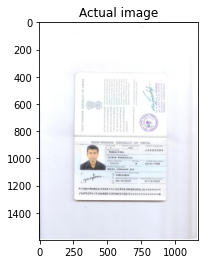

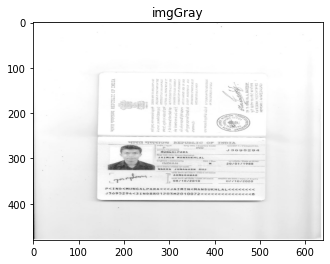

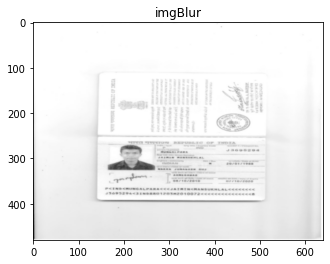

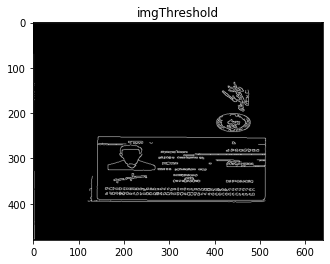

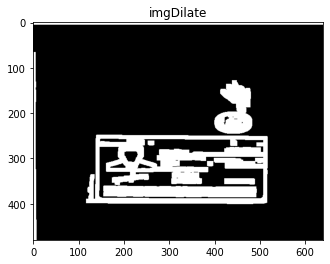

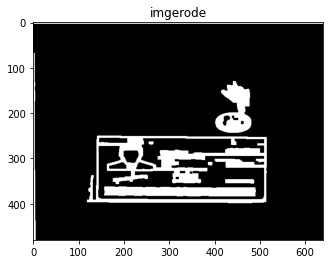

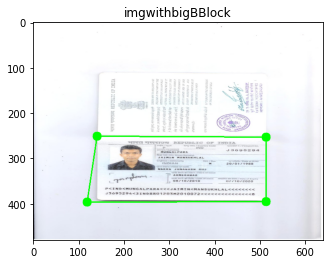

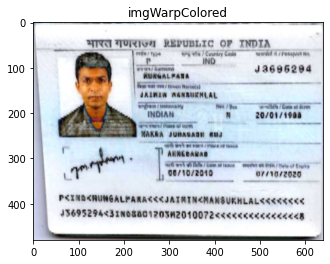

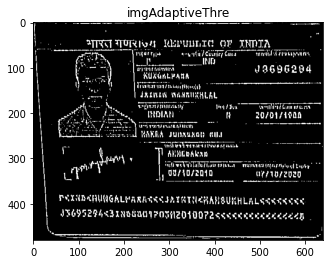

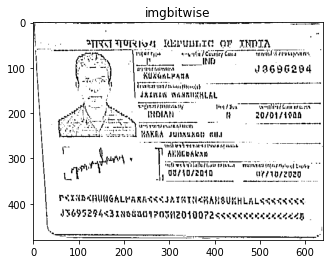

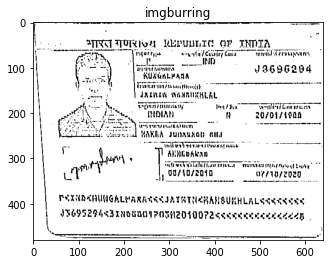

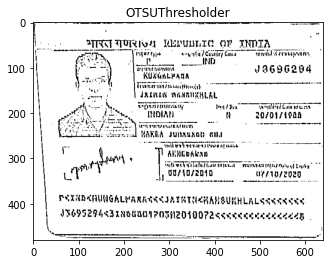

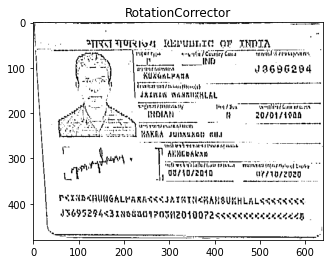

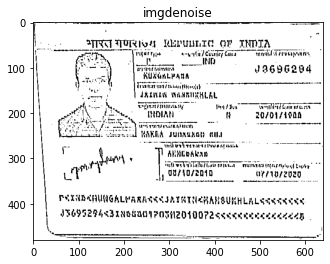

In [5]:
img = cv2.imread(pathImage)
plt_imshow("Actual image",img)
img = cv2.resize(img, (widthImg, heightImg)) # RESIZE IMAGE
imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # CONVERT IMAGE TO GRAY SCALE
plt_imshow("imgGray",imgGray)
imgBlur = cv2.GaussianBlur(imgGray, (3, 3), 1) # ADD GAUSSIAN BLUR
plt_imshow("imgBlur",imgBlur)
#thres=utlis.valTrackbars() # GET TRACK BAR VALUES FOR THRESHOLDS
#thres=valTrackbars() # GET TRACK BAR VALUES FOR THRESHOLDS
imgThreshold = cv2.Canny(imgBlur,10,250) # APPLY CANNY BLUR
plt_imshow("imgThreshold",imgThreshold)
kernel = np.ones((5, 5))
imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
plt_imshow("imgDilate",imgDial)
imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION
plt_imshow("imgerode",imgThreshold)

## FIND ALL COUNTOURS
imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS

# FIND THE BIGGEST COUNTOUR
#biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR
biggest, maxArea = maxContour(contours) # FIND THE BIGGEST CONTOUR
if biggest.size != 0:
    #biggest=utlis.reorder(biggest)
    biggest=reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
    #imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
    imgBigContour = drawRectangle(imgBigContour,biggest,2)
    plt_imshow("imgwithbigBBlock",imgBigContour)
    pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
    pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    img = automatic_brightness_and_contrast(img)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    plt_imshow("imgWarpColored",imgWarpColored)


    #REMOVE 20 PIXELS FORM EACH SIDE
    #imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored,(widthImg,heightImg))

    # APPLY ADAPTIVE THRESHOLD
    imgWarpGray = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)
    #imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpGray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 10)
    plt_imshow("imgAdaptiveThre",imgAdaptiveThre)
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    plt_imshow("imgbitwise",imgAdaptiveThre)
    imgAdaptiveThre=cv2.medianBlur(imgAdaptiveThre,1)
    plt_imshow("imgburring",imgAdaptiveThre)

    # Image Array for Display
    imageArray = ([img,imgGray,imgThreshold,imgContours],
                  [imgBigContour,imgWarpColored, imgWarpGray,imgAdaptiveThre])
    output = OTSUThresholder(imgAdaptiveThre)
    plt_imshow("OTSUThresholder",output)
    output = RotationCorrector(output)
    plt_imshow("RotationCorrector",output)

else:
    img = automatic_brightness_and_contrast(img)
    imgWarpColored = cv2.resize(img,(widthImg,heightImg))

    # APPLY ADAPTIVE THRESHOLD
    imgWarpGray = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)
    plt_imshow("imgWarpColored",imgWarpColored)
    #imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpGray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 10)
    plt_imshow("imgAdaptiveThre",imgAdaptiveThre)
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    plt_imshow("imgbitwise",imgAdaptiveThre)
    imgAdaptiveThre=cv2.medianBlur(imgAdaptiveThre,3)
    plt_imshow("imgburring",imgAdaptiveThre)
    imageArray = ([img,imgGray,imgThreshold,imgContours],
                  [imgBigContour,imgWarpColored, imgWarpGray,imgAdaptiveThre])
    output = OTSUThresholder(imgAdaptiveThre)
    plt_imshow("OTSUThresholder",output)
    output = RotationCorrector(output)
    plt_imshow("RotationCorrector",output)



output = cv2.fastNlMeansDenoising(output, h = 3)
plt_imshow("imgdenoise",output)